# Model training and prediction - `composite`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'/Users/ludvigwarnberggerdin/projects/ttris/pemett'

In [4]:
import pandas as pd

In [5]:
X_train = pd.read_csv("./data/processed/composite/X_train.csv", index_col = 0)
y_train = pd.read_csv("./data/processed/composite/y_train.csv", index_col = 0).composite
X_test = pd.read_csv("./data/processed/composite/X_test.csv", index_col = 0)
y_test = pd.read_csv("./data/processed/composite/y_test.csv", index_col = 0).composite

In [6]:
y_train.value_counts() / len(y_train.index) * 100

0    98.167497
1     1.832503
Name: composite, dtype: float64

In [7]:
cont_features = ["age", "hr", "sbp", "dbp", "spo2", "rr", "delay"]
cat_features = list(X_train.loc[:, ~X_train.columns.isin(cont_features)].columns)

## Run hyper parameter search

In [35]:
import random
from tqdm.notebook import tqdm
from src.models.train_model import generate_all_combinations

In [36]:
import itertools as it
all_breaks = [(0, ) + x + (np.inf,) for x in it.combinations(np.arange(0.01, 1, 0.01), r=3)]

In [37]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [38]:
hyper_parameters = {
    "logisticregression__logisticregression__C": [0.1, 0.2],
    "randomforestclassifier__randomforestclassifier__n_estimators": [100, 200],
    "breaks": all_breaks[:1]
}

In [39]:
numerical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="median", add_indicator=True)),
    ("ss", StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="most_frequent", add_indicator=True)),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
transformers = [
    ("cont", numerical_pipeline, cont_features), 
    ("cat", categorical_pipeline, cat_features)]
preprocessor = ColumnTransformer(transformers=transformers)

In [40]:
lgbm = LGBMClassifier()
lr = Pipeline(steps = [
    ("pp", preprocessor),
    ("logisticregression", LogisticRegression())
])
rf = Pipeline(steps = [
    ("pp", preprocessor),
    ("randomforestclassifier", RandomForestClassifier())
])
base_clfs = [
    lr,
    rf
]

In [41]:
all_hyper_parameters = generate_all_combinations(hyper_parameters)

In [42]:
from src.models.classifiers import StackedGeneralizationClassifier

In [43]:
sg = StackedGeneralizationClassifier(base_clfs = base_clfs, meta_clf = LogisticRegression(), verbose=False)

sg.cv_outer_loop(all_hyper_parameters = all_hyper_parameters, X = X_train, y = y_train, refit=True)

  0%|          | 0/4 [00:00<?, ?it/s]

Outer loop, each fold:
	Number of 0's: ~3054 (98.17%)
	Number of 1's: ~57 (1.83%)
Inner loop, each loop:
	Number of 0's: ~1018 (98.17%)
	Number of 1's: ~19 (1.83%)


ValueError: X has 2 features, but LogisticRegression is expecting 1 features as input.

In [ ]:
y_test_pred_con, y_test_pred_cut = sg.predict(X_test)

In [ ]:
("Hold-out continous model: " + 
str(roc_auc_score(y_score = y_test_pred_con, y_true = y_test)))

'Hold-out continous model: 0.9560772773797339'

In [ ]:
("Hold-out continous model: " + 
str(roc_auc_score(y_score = y_test_pred_cut, y_true = y_test)))

'Hold-out continous model: 0.8835081883316274'

In [ ]:
from src.visualization.visualize import plot_roc, plot_precision_recall

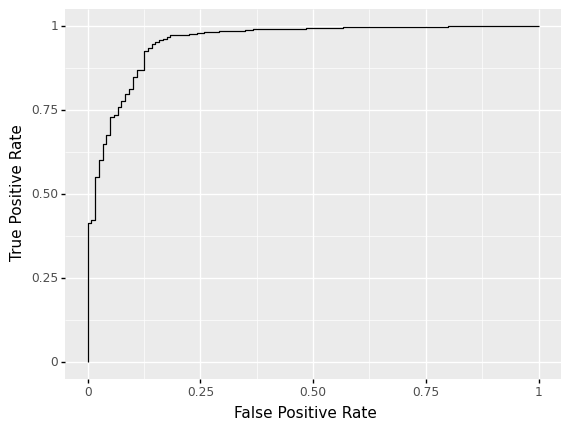

<ggplot: (379068978)>

In [ ]:
plot_roc(y_test, y_test_pred_con)

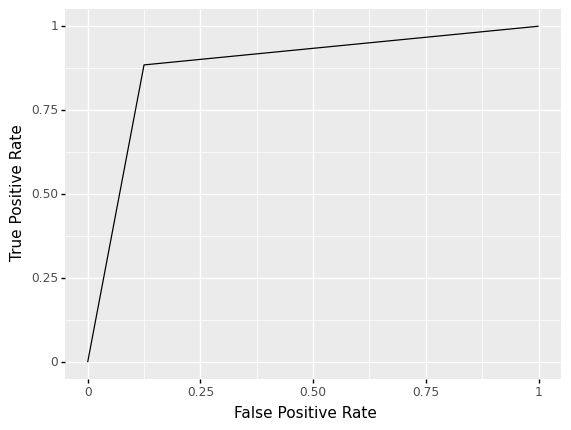

<ggplot: (356967175)>

In [ ]:
plot_roc(y_test, y_test_pred_cut)

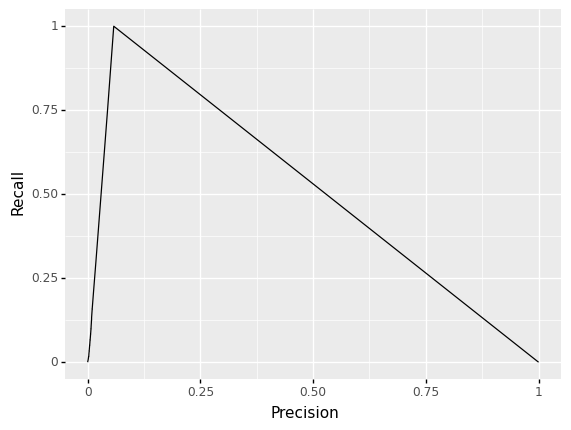

<ggplot: (379214701)>

In [ ]:
plot_precision_recall(y_test, y_test_pred_con)